In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Notebook Outline
**Introduction**

* Brief overview of the project objective and the dataset.
**Setup**

* Import necessary libraries (e.g., NumPy, pandas, TensorFlow/Keras).
**Data Loading**

* Code to load train.csv and test.csv datasets from the zipped files.
* Display the first few rows of the dataset to ensure it's loaded correctly.
**Data Preprocessing**

* Normalize pixel values to be between 0 and 1.
* Reshape images from flat vectors to 28x28 pixel arrays.
* One-hot encode the labels for the training data.
**Exploratory Data Analysis (EDA)**

* Visualize some images from the dataset.
* Analyze the distribution of digits in the training data.
**Model Building**

* Define a neural network model for digit classification. Considering the data, a simple CNN or MLP model will be used.
* Compile the model with an appropriate optimizer, loss function, and metrics.
**Model Training**

* Train the model with the training dataset, using a validation split to monitor performance.
* Plot training history (accuracy and loss over epochs).
**Model Evaluation**

* Evaluate the model on a test set or a validation set to get the final accuracy.
* Display a confusion matrix and classification report.
**Predictions for Submission**

* Predict labels for the test dataset.
* Prepare a submission file format as specified (ImageId,Label).
**Conclusion**

* Summarize the findings, model performance, and any insights gained during the project.
# Starting with Data Loading


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
# Load the dataset
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

# Display the first few rows of the train dataset
train_df.head()

2024-03-06 04:39:26.962368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 04:39:26.962662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 04:39:27.138533: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Preprocessing
1. **Normalize the Pixel Values:** Neural networks work best with data normalized to have a mean close to 0 and a standard deviation close to 1. Since our pixel values range from 0 to 255, we can simply divide by 255 to normalize them to the range [0, 1].
 
1. **Reshape the Images:** The images in the MNIST dataset are 28x28 pixels, but they are flattened into 1D arrays of 784 values in the CSV file. We need to reshape them back into 2D format to feed them into our model correctly.
 
1. **One-hot Encode the Labels:** The labels are currently single integers representing the digit in the image. We'll convert these to one-hot encoded vectors, which is a standard format for categorical targets in machine learning models.

In [4]:
# Separate features and target variable
X_train = train_df.drop("label", axis=1).values.astype('float32')
y_train = train_df["label"].values
X_test = test_df.values.astype('float32')

# Normalize the pixel values to be between 0 and 1
X_train /= 255
X_test /= 255

# Reshape the images to 28x28 pixels
X_train = X_train.reshape(-1, 28, 28, 1)  # Adding dimension for channel (grayscale)
X_test = X_test.reshape(-1, 28, 28, 1)

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes=10)

# Display the new shape of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_encoded shape:", y_train_encoded.shape)


X_train shape: (42000, 28, 28, 1)
X_test shape: (28000, 28, 28, 1)
y_train_encoded shape: (42000, 10)


# Exploratory Data Analysis (EDA)
1. **Visualize Images from the Dataset:** It's helpful to see what the images look like and understand the variability in handwriting styles across the dataset.

1. **Analyze the Distribution of Digits:** Checking the distribution of digits (0 through 9) can help us identify if the dataset is balanced or if there are any biases we need to be aware of.

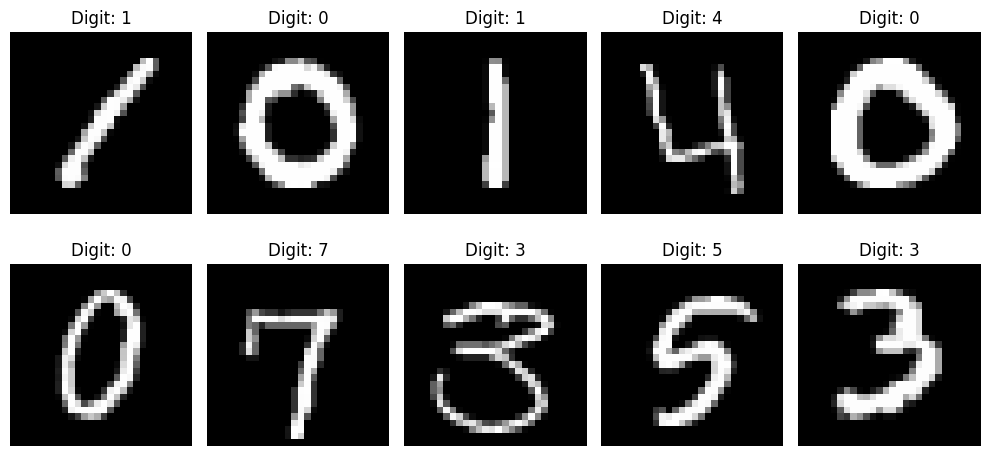

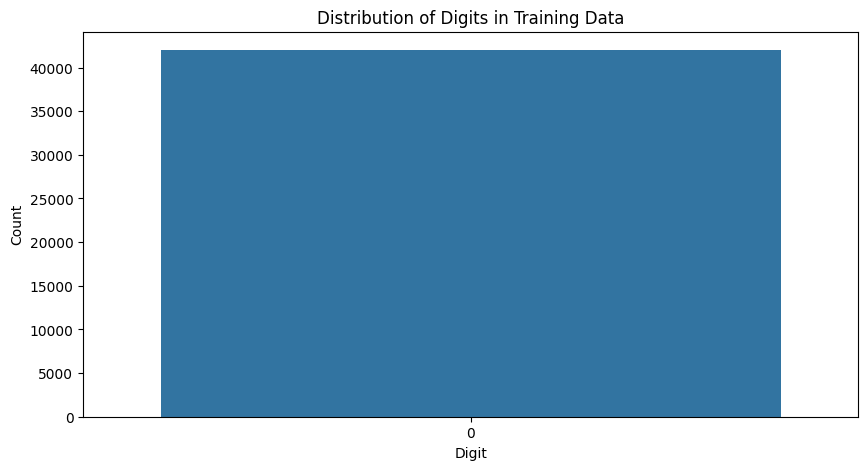

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to display images in a grid
def display_images(images, labels, nrows=2, ncols=5):
    plt.figure(figsize=(10, 5))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(images[i].reshape(28,28), cmap='gray')
        plt.title('Digit: {}'.format(labels[i]))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display images from the training dataset
display_images(X_train, y_train, nrows=2, ncols=5)

# Analyze the distribution of digits in the training dataset
plt.figure(figsize=(10, 5))
sns.countplot(y_train)
plt.title('Distribution of Digits in Training Data')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


# Model Building
1. **Import Necessary Libraries:** First, we import the necessary components from Keras to build our neural network.

1. **Define the Model Architecture:** We will design a simple yet effective CNN architecture for our task.
 
1. **Compile the Model:** After defining the model, we need to compile it with an appropriate optimizer, loss function, and metric(s) for evaluation.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    return model

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer=Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

This model starts with two sets of convolutional and max pooling layers for feature extraction from the images, followed by a flattening layer to transform the 2D feature maps into a 1D vector. After that, it includes a dense layer for classification, a dropout layer to prevent overfitting, and finally, a dense output layer with softmax activation to output the probabilities of the 10 digits.

The model is compiled with the Adam optimizer, a common choice for deep learning tasks due to its adaptive learning rate properties, and categorical crossentropy as the loss function since we're dealing with a multi-class classification problem. The accuracy metric will help us evaluate the model's performance.

# Model Training and Evaluation
1. **Split the Training Data:** Although we have a separate test dataset, it's good practice to also have a validation set during training to monitor the model's performance on unseen data. This helps in detecting overfitting early.
 
1. **Train the Model:** We will fit the model to the training data using the model.fit method, also passing in the validation data.

1. **Evaluate the Model:** After training, we'll evaluate the model's performance on the validation set to see how well it does.

Epoch 1/10
263/263 - 12s - 46ms/step - accuracy: 0.8701 - loss: 0.4167 - val_accuracy: 0.9695 - val_loss: 0.1010
Epoch 2/10
263/263 - 20s - 75ms/step - accuracy: 0.9652 - loss: 0.1182 - val_accuracy: 0.9804 - val_loss: 0.0621
Epoch 3/10
263/263 - 10s - 38ms/step - accuracy: 0.9747 - loss: 0.0844 - val_accuracy: 0.9826 - val_loss: 0.0546
Epoch 4/10
263/263 - 10s - 39ms/step - accuracy: 0.9794 - loss: 0.0679 - val_accuracy: 0.9852 - val_loss: 0.0480
Epoch 5/10
263/263 - 10s - 39ms/step - accuracy: 0.9819 - loss: 0.0576 - val_accuracy: 0.9865 - val_loss: 0.0416
Epoch 6/10
263/263 - 10s - 38ms/step - accuracy: 0.9853 - loss: 0.0500 - val_accuracy: 0.9869 - val_loss: 0.0422
Epoch 7/10
263/263 - 10s - 38ms/step - accuracy: 0.9868 - loss: 0.0439 - val_accuracy: 0.9886 - val_loss: 0.0380
Epoch 8/10
263/263 - 10s - 39ms/step - accuracy: 0.9876 - loss: 0.0383 - val_accuracy: 0.9902 - val_loss: 0.0318
Epoch 9/10
263/263 - 10s - 38ms/step - accuracy: 0.9890 - loss: 0.0349 - val_accuracy: 0.9885 - 

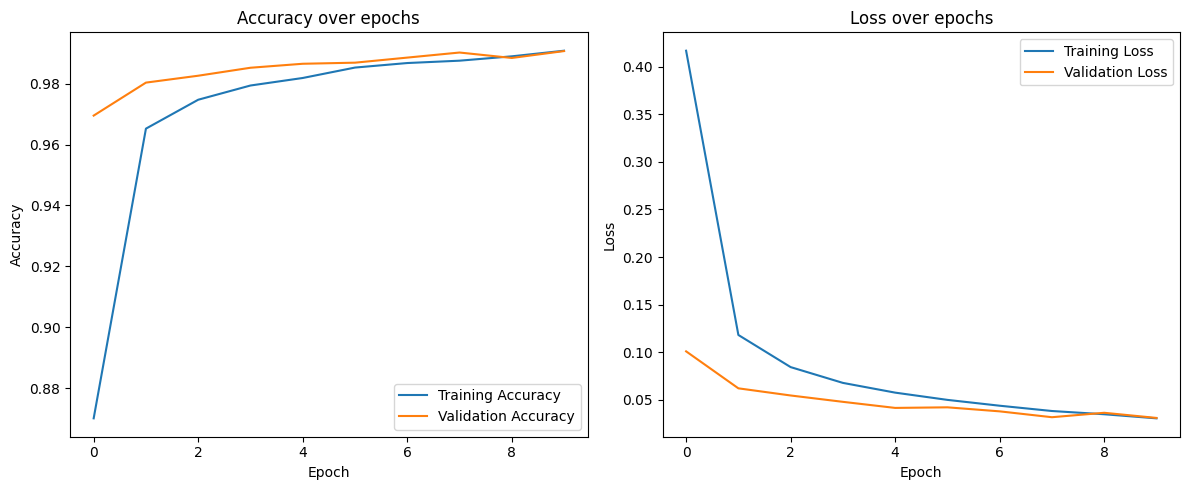

In [7]:
# Splitting the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train_split, y_train_split, 
                    epochs=10, 
                    batch_size=128, 
                    validation_data=(X_val_split, y_val_split),
                    verbose=2)

# Plotting training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [8]:
# Make predictions on the test dataset
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Prepare submission DataFrame
submission = pd.DataFrame({
    "ImageId": list(range(1, len(predicted_classes) + 1)),
    "Label": predicted_classes
})

# Generate submission file
submission_filepath = '/kaggle/working/submission.csv'
submission.to_csv(submission_filepath, index=False)

print(f"Submission file ready: {submission_filepath}")


875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Submission file ready: /kaggle/working/submission.csv
